# Credit Default Prediction (PD Model)
This notebook builds Logistic Regression and CatBoost models to predict probability of default.

## Requirements

The following Python packages are required:

- numpy  
- pandas  
- scikit-learn  
- matplotlib  
- seaborn  
- catboost
- shap

Install (if needed):
pip install catboost shap seaborn scikit-learn

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,ConfusionMatrixDisplay ,classification_report,accuracy_score, precision_score,recall_score

from catboost import CatBoostClassifier

## Load data & EDA

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")

# sometimes there's an ID column that we don't want as a feature
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
df.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [4]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

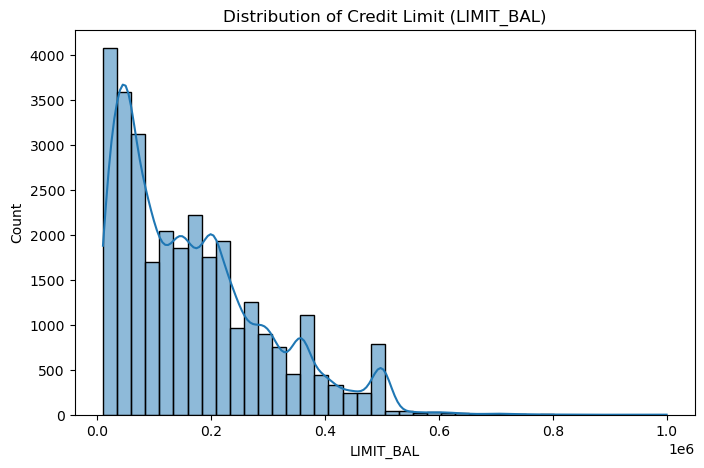

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df['LIMIT_BAL'], kde=True, bins=40)
plt.title("Distribution of Credit Limit (LIMIT_BAL)")
plt.show()

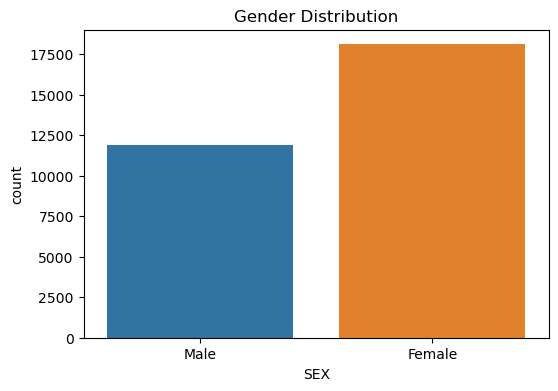

In [7]:
#Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(x='SEX', data=df)
plt.title("Gender Distribution")
plt.xticks([0,1], ['Male','Female'])
plt.show()

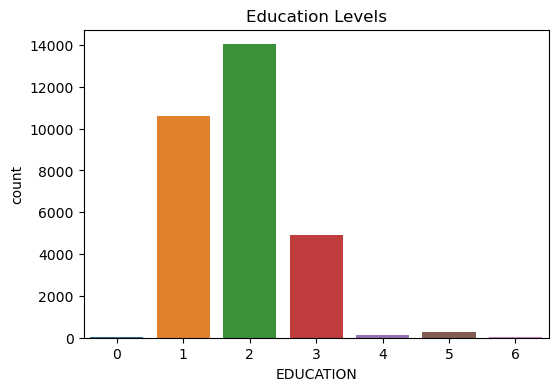

In [8]:
#edu level
plt.figure(figsize=(6,4))
sns.countplot(x='EDUCATION', data=df)
plt.title("Education Levels")
plt.show()

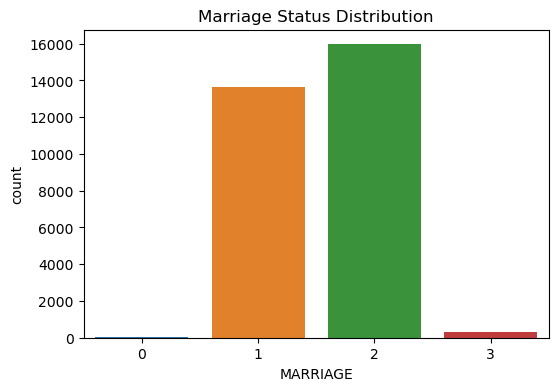

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='MARRIAGE', data=df)
plt.title("Marriage Status Distribution")
plt.show()

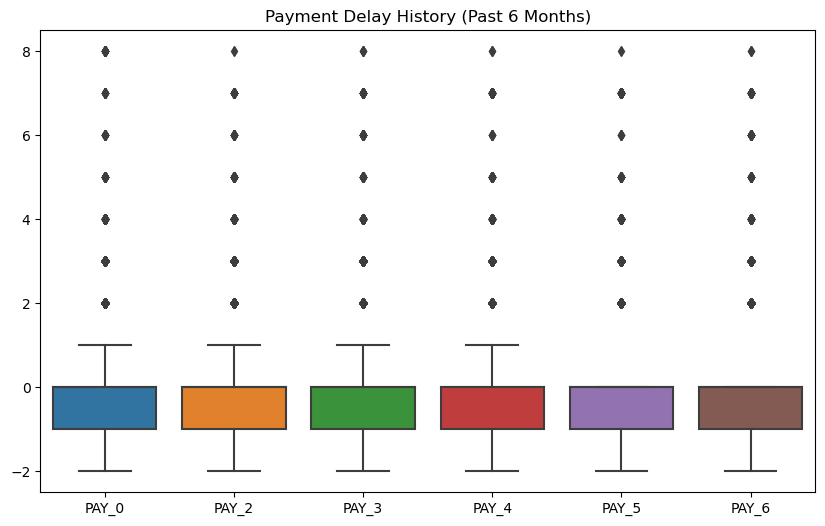

In [10]:
#Payment behavior 
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']])
plt.title("Payment Delay History (Past 6 Months)")
plt.show()

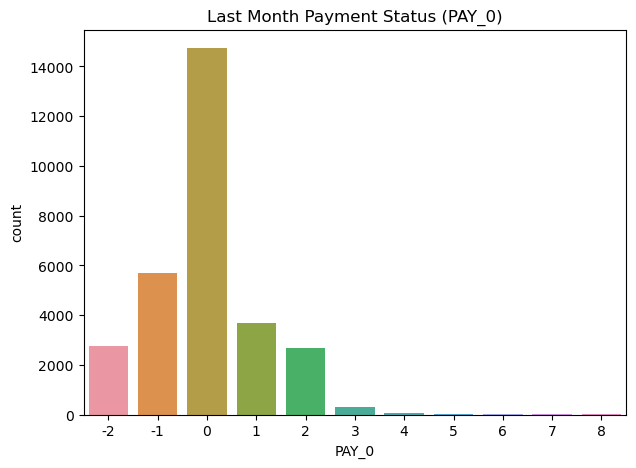

In [11]:
#count of pay last month
plt.figure(figsize=(7,5))
sns.countplot(x='PAY_0', data=df)
plt.title("Last Month Payment Status (PAY_0)")
plt.show()

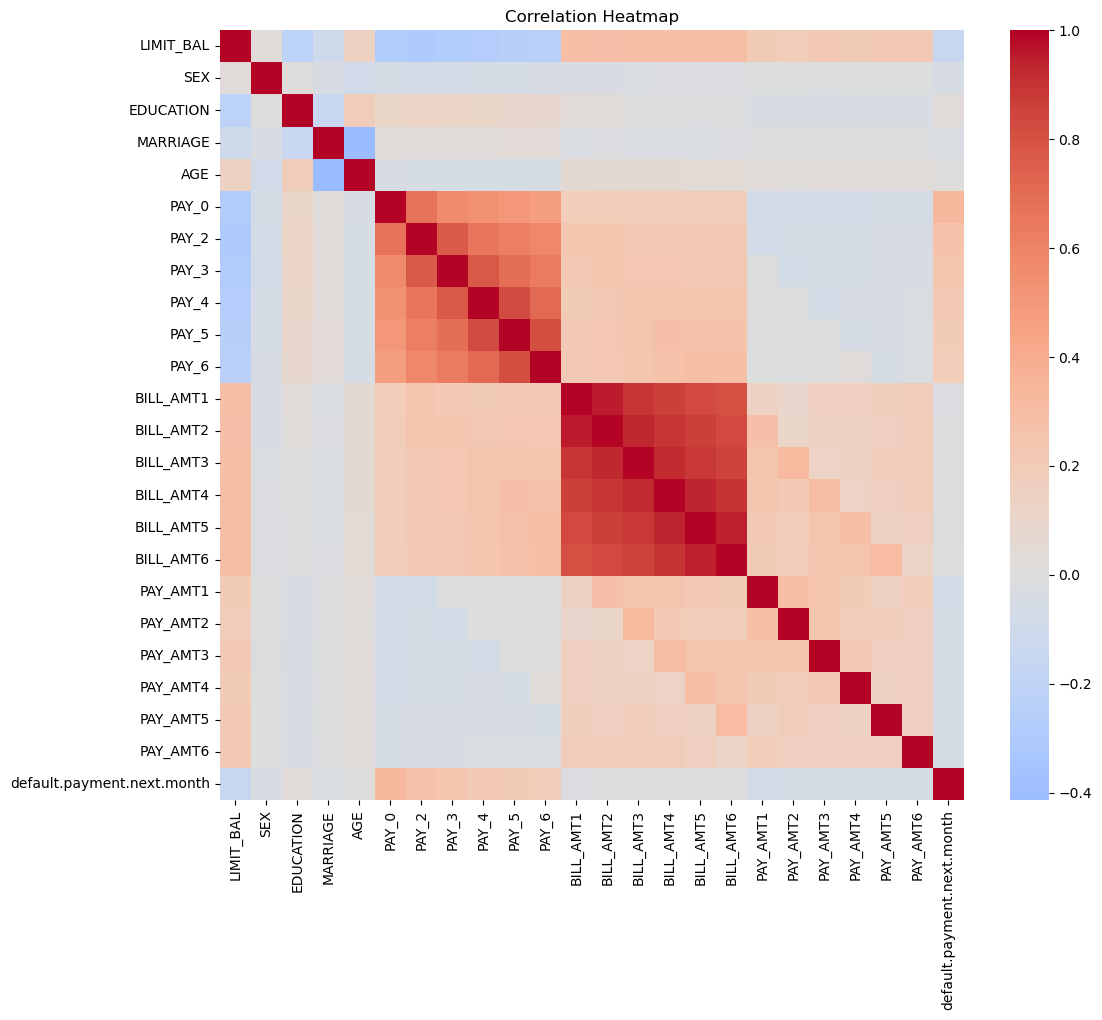

In [12]:
#Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


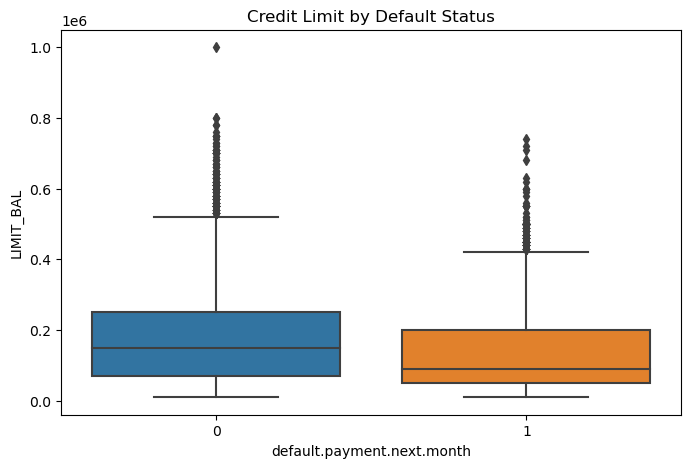

In [13]:
#Dfault and limit LIMIT_BAL
plt.figure(figsize=(8,5))
sns.boxplot(x='default.payment.next.month', y='LIMIT_BAL', data=df)
plt.title("Credit Limit by Default Status")
plt.show()

In [14]:
#identifyint our target col and features cols
target_col = "default.payment.next.month"

X = df.drop(columns=[target_col])
y = df[target_col]

y.value_counts(normalize=True) 

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

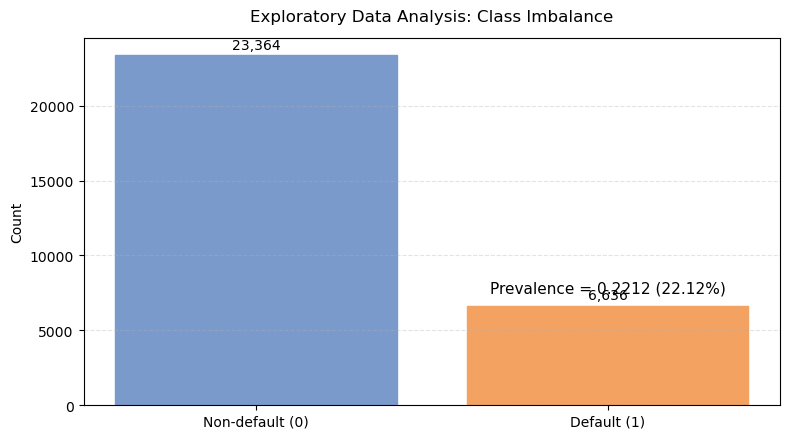

In [15]:

#counts
counts = y.value_counts().sort_index()   # 0 then 1
n0 = int(counts.get(0, 0))
n1 = int(counts.get(1, 0))
prev = n1 / (n0 + n1) if (n0 + n1) > 0 else 0

#plot
labels = ["Non-default (0)", "Default (1)"]
values = [n0, n1]

plt.figure(figsize=(8,4.5))
bars = plt.bar(labels, values, edgecolor="black", linewidth=1.0)

bars[0].set_color("#7b9acc")  # soft steel blue
bars[1].set_color("#f4a261")  # warm orange

plt.title("Exploratory Data Analysis: Class Imbalance", pad=12)
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.35)

# prevalence annotation 
plt.text(
    1, n1 + max(values)*0.03,
    f"Prevalence = {prev:.4f} ({prev*100:.2f}%)",
    ha="center", va="bottom", fontsize=11
)

for i, v in enumerate(values):
    plt.text(i, v + max(values)*0.01, f"{v:,}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

## Train/Val/Test split

In [16]:

# 70% Train, 15% Validation, 15% Test (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (21000, 23) (21000,)
Val: (4500, 23) (4500,)
Test: (4500, 23) (4500,)


## Baseline Logistic Resgression 

In [17]:
#Scaling
scaler = StandardScaler()
#We fit the scaler on the training data to learn the scaling parameters, and then apply the same transformation to both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
log_reg.fit(X_train_scaled, y_train)

# --- y_hat on VALIDATION (for development / threshold selection) ---
y_hat_val = log_reg.predict_proba(X_val_scaled)[:, 1]   # P(default=1)
threshold = 0.5
y_pred_val = (y_hat_val >= threshold).astype(int)

print("First 10 y_hat_val:", y_hat_val[:10])
print("First 10 y_pred_val:", y_pred_val[:10])

# --- Final y_hat on TEST (for final reporting) ---
y_hat_test = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_hat_test >= threshold).astype(int)

print("First 10 y_hat_test:", y_hat_test[:10])
print("First 10 y_pred_test:", y_pred_test[:10])

First 10 y_hat_val: [0.49247957 0.38816837 0.21089656 0.40957838 0.28573927 0.18498335
 0.68599568 0.53518362 0.53230908 0.45004422]
First 10 y_pred_val: [0 0 0 0 0 0 1 1 1 0]
First 10 y_hat_test: [0.48263159 0.47729603 0.74662502 0.53881259 0.79920284 0.33734357
 0.50982599 0.40547336 0.68800587 0.36885089]
First 10 y_pred_test: [0 0 1 1 1 0 1 0 1 0]


In [18]:
from sklearn.metrics import roc_auc_score

# A) Validation:
auc_val = roc_auc_score(y_val, y_hat_val)
print(f"ROC-AUC (val): {auc_val:.4f}")

#B)  Test:
auc_test = roc_auc_score(y_test, y_hat_test)
print(f"ROC-AUC (test): {auc_test:.4f}")

ROC-AUC (val): 0.7135
ROC-AUC (test): 0.7182


## Evaluation (metrics + confusion matrix)

In [19]:
#Evaluation (confusion matrix + metrics)
#A) Confusion matrix, Validation:
cm_val = confusion_matrix(y_val, y_pred_val)
print(cm_val)
#B) Confusion matrix, Test:
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)

[[2449 1056]
 [ 374  621]]
[[2454 1050]
 [ 366  630]]


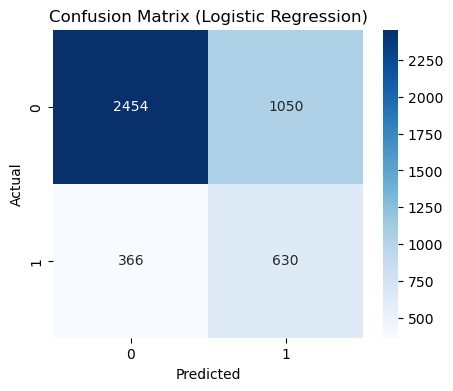

In [20]:
#confusion matrix for Test
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

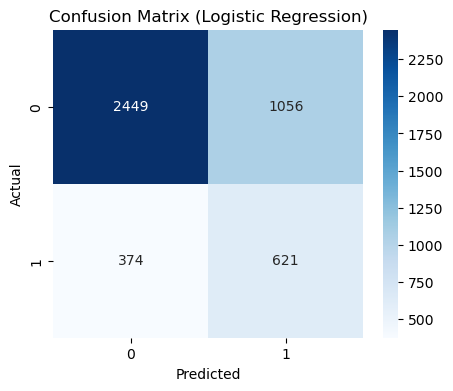

In [21]:
#confusion matrix for validation
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

In [22]:
#metrics
def print_metrics(name, y_true, y_pred):
    print("\n" + "="*40)
    print(name)
    print("="*40)
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred, zero_division=0), 4))
    print("Recall   :", round(recall_score(y_true, y_pred, zero_division=0), 4))
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))

# Validation metrics (development)
print_metrics("Logistic Regression - VALIDATION", y_val, y_pred_val)

# Test metrics (final reporting)
print_metrics("Logistic Regression - TEST", y_test, y_pred_test)


Logistic Regression - VALIDATION
Accuracy : 0.6822
Precision: 0.3703
Recall   : 0.6241

Classification report:
               precision    recall  f1-score   support

           0     0.8675    0.6987    0.7740      3505
           1     0.3703    0.6241    0.4648       995

    accuracy                         0.6822      4500
   macro avg     0.6189    0.6614    0.6194      4500
weighted avg     0.7576    0.6822    0.7057      4500


Logistic Regression - TEST
Accuracy : 0.6853
Precision: 0.375
Recall   : 0.6325

Classification report:
               precision    recall  f1-score   support

           0     0.8702    0.7003    0.7761      3504
           1     0.3750    0.6325    0.4709       996

    accuracy                         0.6853      4500
   macro avg     0.6226    0.6664    0.6235      4500
weighted avg     0.7606    0.6853    0.7085      4500



## CatBoost

In [23]:

cat = CatBoostClassifier(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100
)

cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

0:	test: 0.7484302	best: 0.7484302 (0)	total: 71.3ms	remaining: 56.9s
100:	test: 0.7780361	best: 0.7780361 (100)	total: 481ms	remaining: 3.33s
200:	test: 0.7781428	best: 0.7789029 (117)	total: 951ms	remaining: 2.83s
300:	test: 0.7777497	best: 0.7789029 (117)	total: 1.56s	remaining: 2.58s
400:	test: 0.7769911	best: 0.7789029 (117)	total: 2.22s	remaining: 2.21s
500:	test: 0.7756686	best: 0.7789029 (117)	total: 2.86s	remaining: 1.71s
600:	test: 0.7750129	best: 0.7789029 (117)	total: 3.5s	remaining: 1.16s
700:	test: 0.7737309	best: 0.7789029 (117)	total: 4.13s	remaining: 584ms
799:	test: 0.7733845	best: 0.7789029 (117)	total: 4.75s	remaining: 0us

bestTest = 0.7789029312
bestIteration = 117

Shrink model to first 118 iterations.


## Evaluation (metrics + confusion matrix)

In [24]:
#Evaluation (AUC + confusion matrix) val then Test
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# ---- Validation (for development) ----
y_hat_cb_val  = cat.predict_proba(X_val)[:, 1]
y_pred_cb_val = (y_hat_cb_val >= 0.5).astype(int)

print("CatBoost ROC-AUC (val):", roc_auc_score(y_val, y_hat_cb_val))
print("Confusion Matrix (val):\n", confusion_matrix(y_val, y_pred_cb_val))
print(classification_report(y_val, y_pred_cb_val, digits=4))

# ---- Test (final reporting) ----
y_hat_cb_test  = cat.predict_proba(X_test)[:, 1]
y_pred_cb_test = (y_hat_cb_test >= 0.5).astype(int)

print("CatBoost ROC-AUC (test):", roc_auc_score(y_test, y_hat_cb_test))
print("Confusion Matrix (test):\n", confusion_matrix(y_test, y_pred_cb_test))
print(classification_report(y_test, y_pred_cb_test, digits=4))

CatBoost ROC-AUC (val): 0.778902931203808
Confusion Matrix (val):
 [[3323  182]
 [ 640  355]]
              precision    recall  f1-score   support

           0     0.8385    0.9481    0.8899      3505
           1     0.6611    0.3568    0.4634       995

    accuracy                         0.8173      4500
   macro avg     0.7498    0.6524    0.6767      4500
weighted avg     0.7993    0.8173    0.7956      4500

CatBoost ROC-AUC (test): 0.7830778020758834
Confusion Matrix (test):
 [[3319  185]
 [ 641  355]]
              precision    recall  f1-score   support

           0     0.8381    0.9472    0.8893      3504
           1     0.6574    0.3564    0.4622       996

    accuracy                         0.8164      4500
   macro avg     0.7478    0.6518    0.6758      4500
weighted avg     0.7981    0.8164    0.7948      4500



## We evaluate CatBoost using two thresholds:
	•	Default threshold = 0.5
	•	Tuned threshold = 0.35 (to improve recall of defaulters)

In [25]:
# baseline
y_pred_cb_05 = (y_hat_cb_test >= 0.5).astype(int)

# tuned
THRESHOLD_CB = 0.35
y_pred_cb_035 = (y_hat_cb_test >= THRESHOLD_CB).astype(int)

print(confusion_matrix(y_test, y_pred_cb_05))
print(confusion_matrix(y_test, y_pred_cb_035))

[[3319  185]
 [ 641  355]]
[[3204  300]
 [ 547  449]]


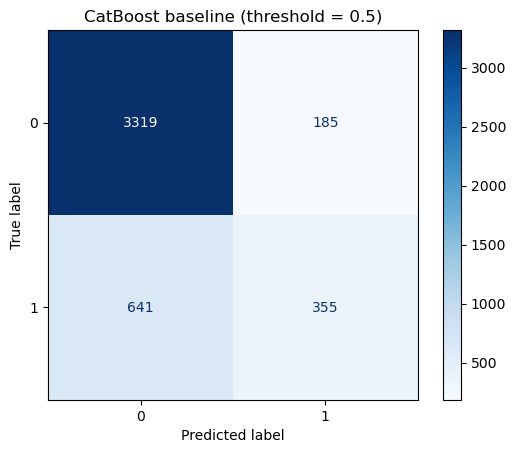

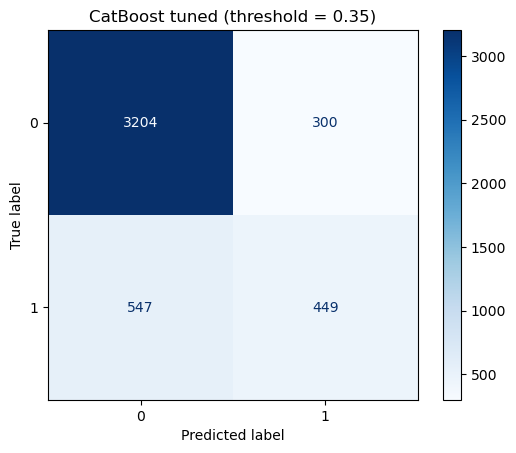

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cb_05,cmap="Blues"
)

plt.title("CatBoost baseline (threshold = 0.5)")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cb_035,cmap="Blues"
)
plt.title("CatBoost tuned (threshold = 0.35)")
plt.show()

In [27]:
from sklearn.metrics import classification_report

print("CatBoost (threshold=0.5)")
print(classification_report(y_test, y_pred_cb_05))

print("CatBoost (threshold=0.35)")
print(classification_report(y_test, y_pred_cb_035))

CatBoost (threshold=0.5)
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3504
           1       0.66      0.36      0.46       996

    accuracy                           0.82      4500
   macro avg       0.75      0.65      0.68      4500
weighted avg       0.80      0.82      0.79      4500

CatBoost (threshold=0.35)
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3504
           1       0.60      0.45      0.51       996

    accuracy                           0.81      4500
   macro avg       0.73      0.68      0.70      4500
weighted avg       0.80      0.81      0.80      4500



In [28]:
print("=== FINAL MODEL COMPARISON ===")

print(f"Logistic Regression ROC-AUC (test): {roc_auc_score(y_test, y_hat_test):.4f}")
print(f"CatBoost ROC-AUC (test): {roc_auc_score(y_test, y_hat_cb_test):.4f}")

=== FINAL MODEL COMPARISON ===
Logistic Regression ROC-AUC (test): 0.7182
CatBoost ROC-AUC (test): 0.7831


## SHAP

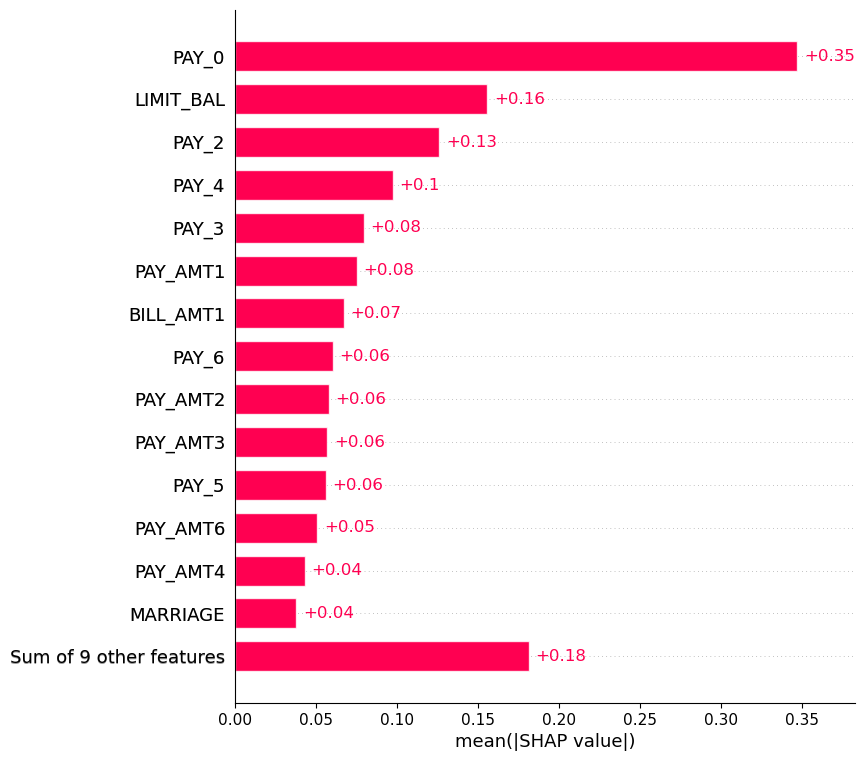

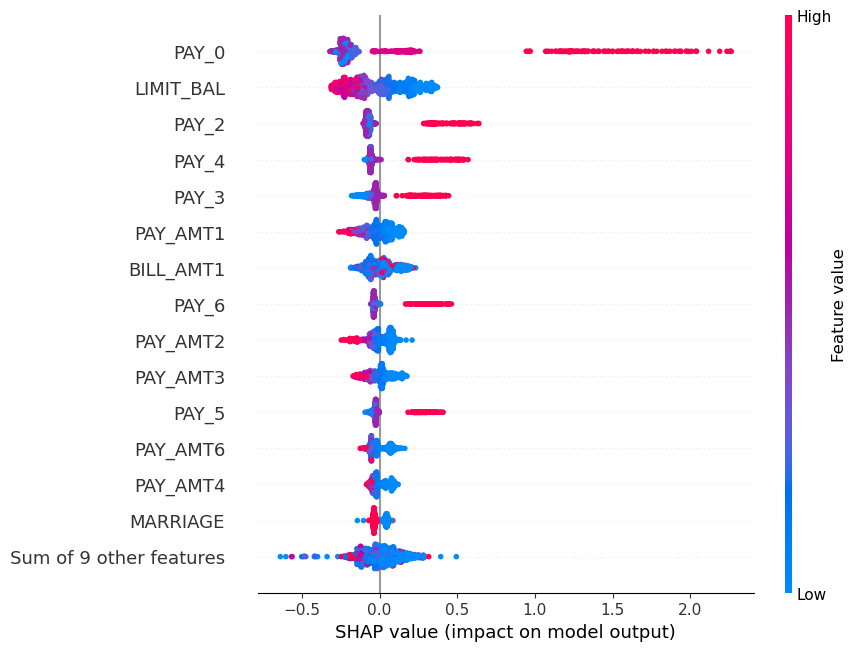

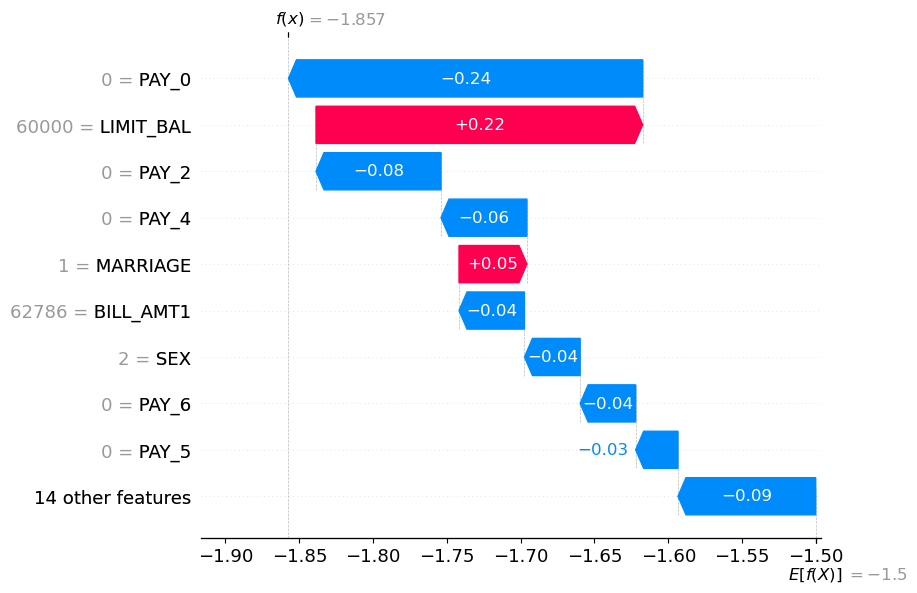

In [29]:
# SHAP explanation for CatBoost model
#a sample of 1000
X_shap = X_test.sample(1000, random_state=42)

# SHAP explainer
explainer_cb = shap.Explainer(cat)          # works well with CatBoost
sv_cb = explainer_cb(X_shap)                # shap values as Explanation object

# Global importance
shap.plots.bar(sv_cb, max_display=15)
shap.plots.beeswarm(sv_cb, max_display=15)

# Local explanation
shap.plots.waterfall(sv_cb[0])

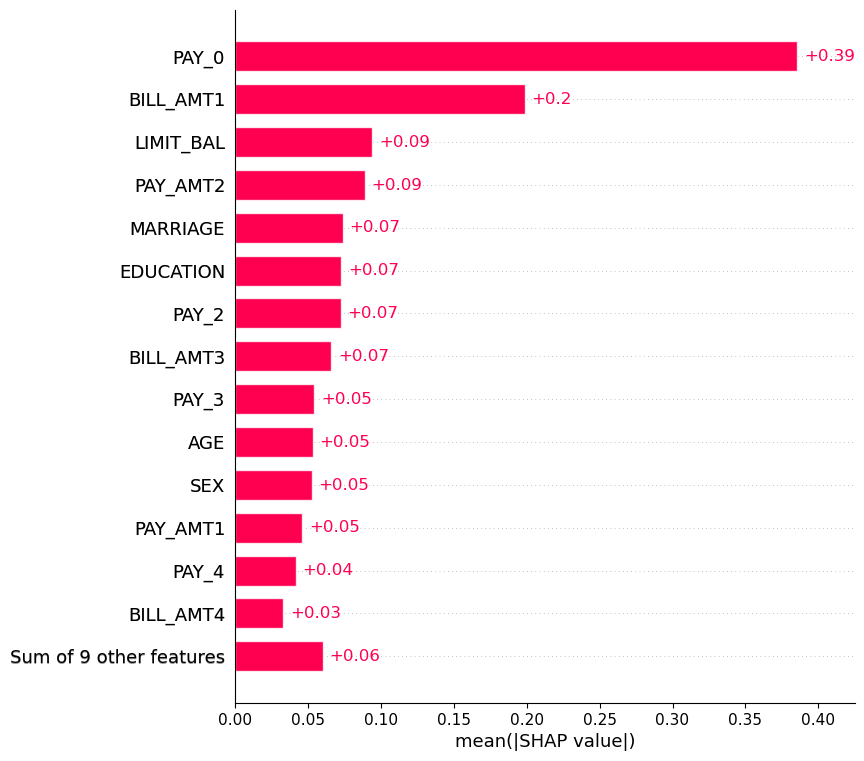

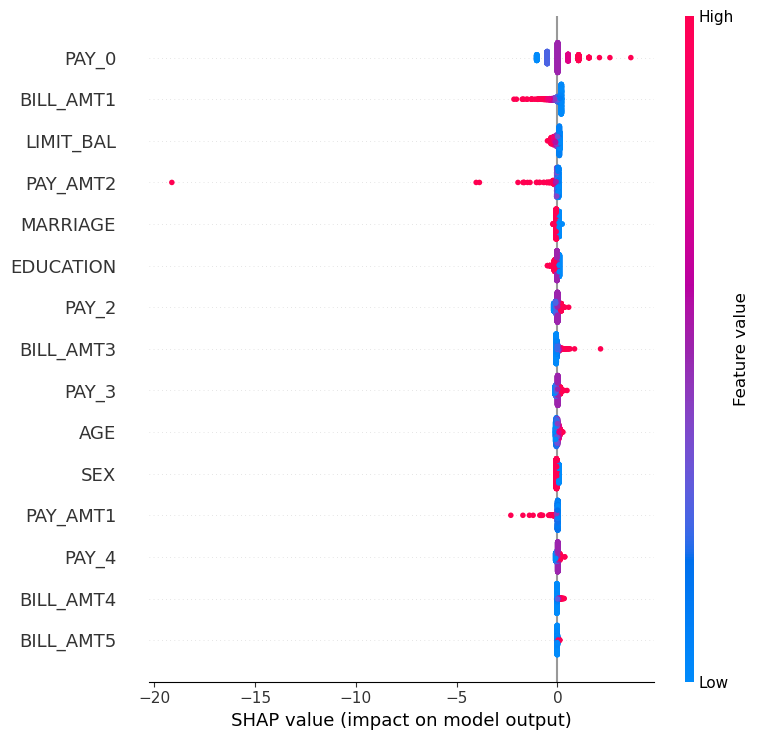

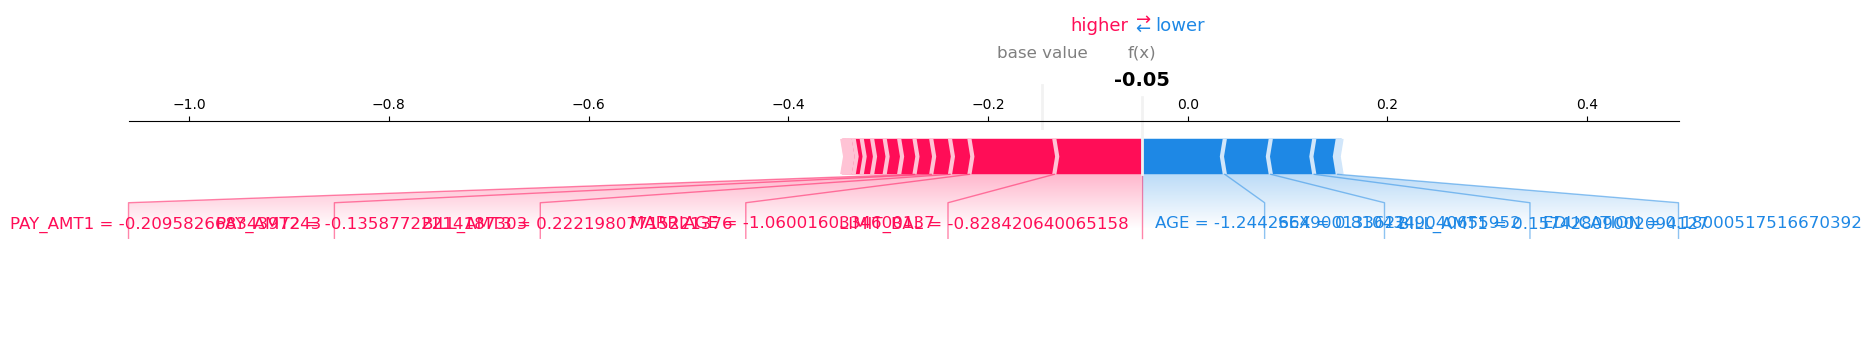

In [30]:
# SHAP explanation for Logistic Regression model

# DataFrame scaled features
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# sample for speed
X_shap_lr = X_test_scaled_df.sample(1000, random_state=42)

explainer_lr = shap.LinearExplainer(log_reg, X_train_scaled_df)
sv_lr = explainer_lr(X_shap_lr)

# Global
shap.plots.bar(sv_lr, max_display=15)
shap.summary_plot(sv_lr.values, X_shap_lr, max_display=15)

# Local 
i = 0
shap.force_plot(explainer_lr.expected_value, sv_lr.values[i], X_shap_lr.iloc[i], matplotlib=True)